# Position reconstruction 2.0

(author: B.Paetsch, updated: 29.06.2020)

For a more precise interaction position reconstruction, the average radial position of multiple PMTs seeing a significant signal is taken for the x- and y-position. Therefore the channellist in the waveform reader is moified, so that we now get a list with each PMT and its lowest (gain corrected) adc value that contributes to the recorded signal. The channellist is sorted by adc value (starting with the lowest), and according PMTs to the first three entries are taken for the position reconstruction. Here we look at all signals, but since only the top PMTs are taken into account, mostly or exlusively S2 signals are amongst the maximal ones.

(Waveform reader and position function are modified)

In [26]:
import Zip
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time, sys, pickle, math
from IPython.display import clear_output

# Channels in the detector
det_ch = { 'tpc': list(range(0, 247+1)), 'veto': list(range(248, 253+1)), 
          'sum_wv': [254], 'busy_on': [255], 'busy_off': [256],
          'hev_on': [257], 'hev_off': [258], 'muon_veto_trigger': [259], } 
n_channels = 260

# for reading the ini file
from configparser import ConfigParser, ExtendedInterpolation
config = ConfigParser(inline_comment_prefixes='#', interpolation=ExtendedInterpolation(), strict=True)
config.optionsxform = str
config.read('xenon1t.ini')

ch_top = eval(config['DEFAULT']['channels_top'])
gain = eval(config['DEFAULT']['gains'])

# Initial parameters
baseline_ = 16384. * np.ones(n_channels)
std_ = 2.3 * np.ones(n_channels)

# The data files
NG = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/NG") # Neutron data
Rn220 = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/Rn220") # Rn-220 data

In [27]:
#progress bar for running code
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [28]:
"""take gains into account for each adc value"""
"""only look at top PMTs (for position reconstruction)"""
"""the channellist is modified!!!"""
def myFunc(e):
    return e["adc_corrected"]

# A waveform reader function
def Waveform(raw,eventnr):
    event = raw.get_single_event(eventnr)
                                
    #The variables that check if a channel is the minimum channel
    adcmin = 16382
    minchannel = 0
    
    #A list that holds all the channels with significant pulses 
    channellist = []
    
    #Create the datapoint arrays
    n = 350000  
    ts = np.ones((n_channels, n), dtype=np.int16)
    ts = ts * 16382 
    t = np.linspace(0, n, n) 
    counter = False
    first = True
    
    #Loop over all pulses in the event
    for p in event.pulses:
        ch = p.channel
        if ch in ch_top:  #only top PMTs
            i = np.zeros(n_channels, dtype = int)
            for adc in p.raw_data:
                if gain[ch]!=0:
                    adc_corrected = 16382 - (16382 - adc)/gain[ch]*4911399 #corrected by relative gain
                else:
                    adc_corrected = 0 #np.inf #if we put 0 here, PMTs with 0 gain are taken into account for minchannel
                #print("not corrected: ", adc, "corrected: ",adc_corrected)
                try:
                #Add the ADC value to the appropriate channel array
                    #ts[ch][p.left + i[ch]] = adc #(not corrected)
                    ts[ch][p.left + i[ch]] = adc_corrected
                    i[ch] = i[ch] + 1
                except IndexError:
                        counter = True
                """This part is modified!!!"""        
                #Append all significant main channels to the channellist with their adc_corrected value
                if adc_corrected < 15000 and ch in det_ch['tpc']:   
                    #if it isn't in list, append
                    if first or len(list(filter(lambda value:value["channel"]==ch,channellist)))==0:
                        entry = {'channel': ch, 'adc_corrected': adc_corrected}
                        channellist.append(entry)
                        first = False
                    #if it is already in list, check whether adc value is now lower, if so take as new value    
                    else:                      
                        ind = channellist.index(list(filter(lambda value:value["channel"]==ch,channellist))[0])
                        if channellist[ind]['adc_corrected']>adc_corrected:
                            channellist[ind]['adc_corrected']=adc_corrected
                
                #Check which channel is the minimum channel
                if adc_corrected!=0 and adc_corrected < adcmin:
                    adcmin = adc_corrected
                    minchannel = ch
                if ch in channellist:
                    print(ch)
                
    #Sort by highest adc value
    channellist.sort(key= myFunc) #["adc_corrected"])
    return t, ts, channellist, minchannel, counter

In [29]:
#from Joey Staa
def Peaks(pulse, printall):
    
    # The standard variables
    q = 0
    left_t, right_t = 0, 0
    baseline = 16382.
    std = 2.3
    ch = pulse.channel
    wave = pulse.raw_data
    
    # The index for the minimum
    minindex = len(wave)
    
    # Variables for the average, the ratio and the slope
    avfound = 0
    samplelist = [wave[0]]
    ratio = 1
    slope = 0
    sw = 0

    s = np.std(wave)
    delta = baseline - np.min(wave)
    if min(s, delta) > 5*std:
        for samples in enumerate(wave):
            base_sub = samples[1] - baseline
            if abs(base_sub) > 5*std:
                q = q + base_sub
            
            # Compute the average of the previous samples
            av = np.average(samplelist)
            
            # left_t is assigned when a significant deviation from the average is recorded
            if abs(samples[1] - av) > 20 and left_t == 0:
                left_t = samples[0]
                
                # The sample value at left_t is kept for the slope calculation
                leftsample = samplelist[-1]
                if printall:
                    print("left_t here")
                avfound = av
             
            # Find the index for the minimum
            if samples[1] == np.min(wave):
                minindex = samples[0]

            # right_t is assigned in a similar way as left_t
            if abs(samples[1] - avfound) < 20 and samples[0] > minindex and right_t == 0: 
                right_t = samples[0]
                if printall:
                    print("right_t here")
                
            # Add the current sample to the sample list
            samplelist.append(samples[1])
            
            # A printing section in case the raw data needs to be analysed
            if printall:
                print(samples)
                print("Average:", av)
                if left_t == 0:
                    print("Average difference:", abs(samples[1] - av))
                else:
                    print("Average difference:", abs(samples[1] - avfound))
                print()
        
        # Calculate the ratio and the slope
        ratio = np.min(wave)/int(avfound)
        delta_x = minindex - left_t
        if delta_x != 0:
            slope = (np.min(wave) - leftsample)/delta_x
        
    else:
        baseline = np.average(wave)
        std = s
    width = right_t - left_t
    if width != 0:
        sw = slope/width
        if -q/width < 3*std or ratio >= 0.99:
            q = 0
    return (ch, q, width, pulse.left+left_t, sw)

In [30]:
#getting the already classified S1 and S2 signals stored in a list (Zhuoran Feng)
#(first 10000 events)

#with open ('NG_data_new.p','rb') as fp:
with open ('Rn220_data_new.p','rb') as fp:    
    data = pickle.load(fp)

In [31]:
#checking whether it works
print(data[0])
print(len(data))
print(data[0]['event'])

{'event': 0, 's1': 110469.0, 's2': 1311152.0, 's1_position': 100055, 's2_position': 171748}
7490
0


In [32]:
# that's how you can enter one entry
list(filter(lambda value:value["event"]==0,data))

[{'event': 0,
  's1': 110469.0,
  's1_position': 100055,
  's2': 1311152.0,
  's2_position': 171748}]

In [33]:
(t, ts, channellist, minchannel, counter) = Waveform(Rn220,3)
channellist[0]['channel']

117

In [34]:
channellist[1]

{'adc_corrected': -17031.808009891269, 'channel': 103}

In [40]:
#you need the Waveform reader, Peaks-function and the classified S1 and S2 signal list for running position-fct.
def position(raw,data):
    """ Finding the x,y and z position for an event, and storing the coordinates in a list.
    Only channel 254 is used."""
    
    position_list = []
    s2fors1 = 0
    c = 0
    z = 0
    drift_velocity = 1.44 # mm/us, see Jelle p.78 or 1708.07051
    length_data = len(data)
    
    for event in data:
        if event['s1_position']<event['s2_position']:
            #z-coordinate
            #difference between two datapoints in waveform: 10ns (=1e-2 us)
            drift = 1e-2*(event['s2_position']-event['s1_position'])
            z = drift * drift_velocity #[mm]
        
            """This part is modified!!!"""
    #x-,y-coordinate (we take the average radial position of up to three PMTs (strongest signal))
            (t, ts, channellist, minchannel, counter) = Waveform(raw,event['event'])
            if counter == True: #counts how many events we skipped due to a broad scintillation signal
                c += 1
            pmt = eval(config['DEFAULT']['pmts'])
            
            #the x and y coordinates of up to three PMTs with the strongest signal (sometimes we only have 2 or 1)
            if len(channellist)>2:
                x1 = pmt[channellist[0]['channel']]['position']['x']
                x2 = pmt[channellist[1]['channel']]['position']['x']
                x3 = pmt[channellist[2]['channel']]['position']['x']
                x_avg = (x1+x2+x3)/3
            
                y1 = pmt[channellist[0]['channel']]['position']['y']
                y2 = pmt[channellist[1]['channel']]['position']['y']
                y3 = pmt[channellist[2]['channel']]['position']['y']
                y_avg = (y1+y2+y3)/3
                
            if len(channellist)==2:
                x1 = pmt[channellist[0]['channel']]['position']['x']
                x2 = pmt[channellist[1]['channel']]['position']['x']
                x_avg = (x1+x2)/2
            
                y1 = pmt[channellist[0]['channel']]['position']['y']
                y2 = pmt[channellist[1]['channel']]['position']['y']
                y_avg = (y1+y2)/2
                
            if len(channellist)==1:
                x_avg = pmt[channellist[0]['channel']]['position']['x']
                y_avg = pmt[channellist[0]['channel']]['position']['y']
            
            
            
            entry = { 'eventnumber': event['event'], 'x': x_avg, 'y': y_avg, 
                     'z': z }
            position_list.append(entry)
            length = len(position_list)
        
            if (length/length_data)%0.1==0: #every 10% update the progress bar
                update_progress(length/length_data) 
            #if length==10:
            #   break
        else:
            s2fors1 += 1     
    
    print("S2 signal before S1 signal: ", s2fors1)        
    return position_list, c #c: counter, how many events we skipped in Waveform-fct. due to a size>350000 

In [ ]:
#create the position_list
start_time = time.time()

#position_list, counter = position(NG,data)
position_list, counter = position(Rn220, data)

print("position_list execution runtime: ", time.time()-start_time) #seconds

Progress: [########------------] 40.0%


In [18]:
print(counter)
"""NG: event 23 has a length of 350000 + 185342 = 535342 
For more information on the waveforms that are broader than 350000 and are skipped in the x-y-position 
determination, have a look at the 'ample_size.ipynb' notebook. """

print(len(position_list))
print(position_list[0])

729
7467
{'eventnumber': 0, 'x': 15.90000000000001, 'y': 27.53960784034514, 'z': 1032.3792}


In [ ]:
print(position_list[0]['x'])

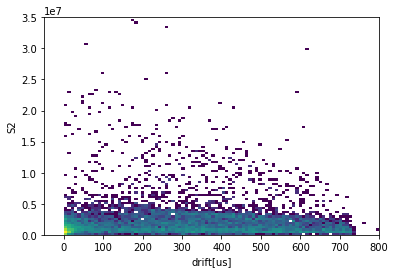

In [57]:
#plotting the drift time
s1 = []
s2 = []
drift = []
for event in data:
    if event['s1_position']<event['s2_position']: 
        drift.append(1e-2*(event['s2_position']-event['s1_position']))
        s1.append(event['s1'])
        s2.append(event['s2'])
fig, ax = plt.subplots()
ax.hist2d(drift,s2, bins=(100,100), range=((-50,800),(0,3.5*1e7)), norm=mpl.colors.LogNorm())
ax.set_xlabel("drift[us]")
ax.set_ylabel("S2")
ax.set_title("NG z-position")
#fname = 'NG_drift10000.png'
#fig.savefig(fname, dpi = (200))

In [50]:
#plotting the x-, y- and z-coordinate
x = np.array([])
y = np.array([])
z = np.array([])
for position in position_list:
    #print(position)
    x = np.append(x,position['x'])
    y = np.append(y,position['y'])
    z = np.append(z,position['z'])
print(len(x))
print(len(s2))

7467
7467


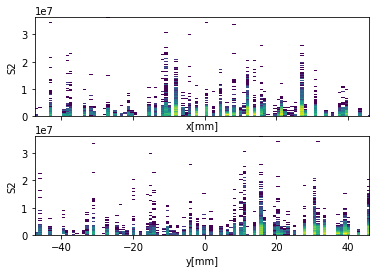

In [56]:
fig, ax = plt.subplots(2, 1, sharex='col')
ax[0].hist2d(x,s2, bins=(100,100), norm=mpl.colors.LogNorm())
ax[1].hist2d(y,s2, bins=(100,100), norm=mpl.colors.LogNorm())
ax[0].set_xlabel("x[mm]")
ax[1].set_xlabel("y[mm]")
ax[0].set_ylabel("S2")
ax[1].set_ylabel("S2")
fname = 'Rn_improvedxy.png'
fig.savefig(fname, dpi = (200))

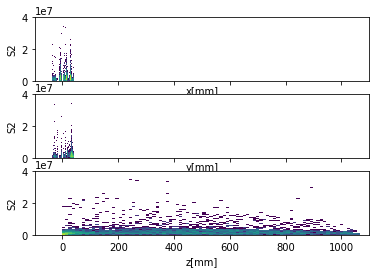

In [58]:
fig, ax = plt.subplots(3, 1, sharex='col')
ax[0].hist2d(x,s2, bins=(100,100), range=((-100, 100),(0, 40000000)), norm=mpl.colors.LogNorm())
ax[1].hist2d(y,s2, bins=(100,100), range=((-100, 100),(0, 40000000)), norm=mpl.colors.LogNorm())
ax[2].hist2d(z,s2, bins=(100,100), range=((-100, 1100),(0, 40000000)), norm=mpl.colors.LogNorm())
ax[0].set_xlabel("x[mm]")
ax[1].set_xlabel("y[mm]")
ax[2].set_xlabel("z[mm]")
ax[0].set_ylabel("S2")
ax[1].set_ylabel("S2")
ax[2].set_ylabel("S2")
#fname = 'Rn_improvedPosition.png'
#fig.savefig(fname, dpi = (200))

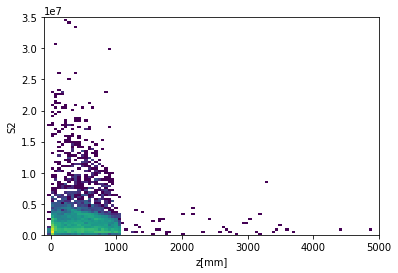

In [62]:
fig, ax = plt.subplots()
ax.hist2d(z,s2, bins=(100,100), range=((-100,5000),(0,3.5*1e7)), norm=mpl.colors.LogNorm())
ax.set_xlabel("z[mm]")
ax.set_ylabel("S2")
#fname = 'Rn_improved_z.png'
#fig.savefig(fname, dpi = (200))

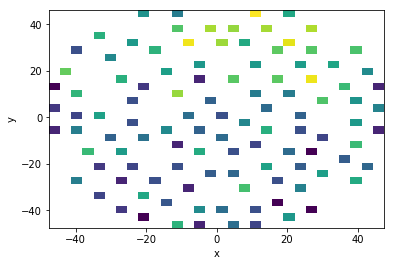

In [63]:
fig, ax = plt.subplots()
ax.hist2d(x,y, bins=(30,30), norm=mpl.colors.LogNorm())
ax.set_xlabel("x")
ax.set_ylabel("y")
#fname = 'Rn_improvedHitpattern.png'
#fig.savefig(fname, dpi = (200))

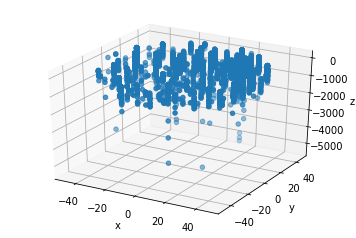

In [66]:
from mpl_toolkits.mplot3d import Axes3D 
ax = plt.subplot(projection='3d')
ax.scatter(x, y, -z)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('adc value')

plt.show()


# Outlook

At the moment the PMTs at the first three entries in channellist with the lowest adc value (highest p.e.) are used for the interaction position reconstruction in the x- and y-plane. A preciser reconstruction could be done by adding a criterion that we do not take the first three entries, but the first entry and only additional ones when the recorded adc value for these PMTs (gain corrected) lays in a certain threshold region.

(I did not modify the adchist list due to a lack of time, but that is a possible improvement I have in mind.)